## 1. Perform any cleaning, exploratory analysis, and/or visualizations
to use the provided data for this analysis(a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [1]:
import pandas as pd
import dask
import dask.dataframe as dd
import numpy as np
import json
# from datetime import datetime
import seaborn as sns
import matplotlib.pylab as plt
# from IPython.display import HTML
import warnings
pd.options.display.max_columns = 32
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [2]:
TRAIN_FILE = './dataset/ultimate_data_challenge.json'

In [3]:
with open(TRAIN_FILE) as f:
    json_data = json.load(f)
    df_data = pd.DataFrame(json_data)
#     df_data = df_data.sample(1000)
    df_data = dd.from_pandas(df_data, 4)

In [4]:
df_data.shape

(Delayed('int-29f1182f-8f11-46bb-b8ae-5a9b8651f450'), 12)

In [5]:
df_data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, avg_dist to weekday_pct
dtypes: object(4), bool(1), float64(6), int64(1)

In [6]:
df_data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [7]:
df_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [8]:
df_data.compute().describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


**signup_date and last_trip_date are string, so these are converted to datetime.**

In [9]:
df_data['last_trip_date'] = dd.to_datetime(df_data['last_trip_date'])
df_data['signup_date'] = dd.to_datetime(df_data['signup_date'])

In [10]:
df_data.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
ultimate_black_user                 bool
weekday_pct                      float64
dtype: object

**We can get a retain flag from wether last_trip_data is after June 1st or not.**

In [11]:
df_data['retained'] = (df_data['last_trip_date'] >= '2014-06-01')*1
display(df_data[['retained','last_trip_date']].head())
display(df_data.retained.value_counts())

,retained,last_trip_date
0,1,2014-06-17
1,0,2014-05-05
2,0,2014-01-07
3,1,2014-06-29
4,0,2014-03-15


Dask Series Structure:
npartitions=1
    int64
      ...
Name: retained, dtype: int64
Dask Name: value-counts-agg, 53 tasks

In [12]:
temp = df_data.compute()
sum(temp.retained*1) / len(temp)

0.37608

**Fill non value data with appropriate values.**

In [13]:
df_data.compute().isnull().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
retained                  False
dtype: bool

In [14]:
avg_rating_by_driver_mean = df_data['avg_rating_by_driver'].mean()
avg_rating_of_driver_mean = df_data['avg_rating_of_driver'].mean()

In [15]:
df_data['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True) 
df_data['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True) 
df_data['phone'].fillna('Other', inplace=True)

In [16]:
display(df_data.compute().isnull().any())

avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                     False
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
retained                  False
dtype: bool

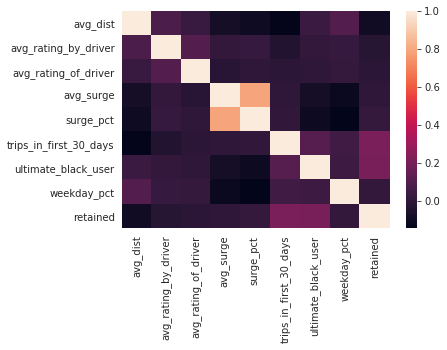

In [17]:
corr = df_data.compute().corr()
ax = sns.heatmap(corr)
plt.show()

In [18]:
corr['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.010829
avg_rating_by_driver     -0.026748
avg_dist                 -0.092780
Name: retained, dtype: float64

**"trips_in_first_30_days" and "ultimate_black_user" are slightly correlated with "retained".**

**Decompose date information**

In [19]:
df_data['signup_date_day'] = df_data['signup_date'].map(lambda x: x.day)
df_data['signup_date_day_of_week'] = df_data['signup_date'].map(lambda x: x.weekday())
del df_data['signup_date']

In [20]:
del df_data['last_trip_date']

In [21]:
df_data['ultimate_black_user'] = df_data['ultimate_black_user']*1

**one-hot-encode**

In [22]:
df_data = df_data.categorize(columns = ['phone', 'city', 'signup_date_day', 'signup_date_day_of_week'])
df_data = dd.get_dummies(df_data, columns=['phone', 'city', 'signup_date_day', 'signup_date_day_of_week'])

In [23]:
df_data.compute().describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,phone_iPhone,phone_Android,phone_Other,city_King's Landing,city_Astapor,city_Winterfell,signup_date_day_25,...,signup_date_day_18,signup_date_day_20,signup_date_day_4,signup_date_day_30,signup_date_day_7,signup_date_day_1,signup_date_day_8,signup_date_day_23,signup_date_day_14,signup_date_day_of_week_5,signup_date_day_of_week_2,signup_date_day_of_week_0,signup_date_day_of_week_4,signup_date_day_of_week_3,signup_date_day_of_week_1,signup_date_day_of_week_6
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,0.37708,60.926084,0.376080,0.691640,0.300440,0.007920,0.202600,0.330680,0.466720,0.057700,...,0.058960,0.025900,0.02970,0.029420,0.029720,0.034740,0.02550,0.032120,0.022400,0.194400,0.133760,0.106860,0.195340,0.138900,0.102480,0.128260
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,0.48466,37.081503,0.484405,0.461821,0.458454,0.088642,0.401941,0.470463,0.498896,0.233178,...,0.235552,0.158839,0.16976,0.168982,0.169815,0.183122,0.15764,0.176321,0.147982,0.395742,0.340398,0.308938,0.396466,0.345846,0.303282,0.334382
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,0.00000,66.700000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,1.00000,100.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,1.00000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Build a predictive model
to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [24]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, r2_score

In [44]:
X = df_data.compute().drop(['retained'], axis=1)
y = df_data['retained'].compute()

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0, stratify=y)

In [26]:
df_data.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,phone_iPhone,phone_Android,phone_Other,city_King's Landing,city_Astapor,city_Winterfell,signup_date_day_25,...,signup_date_day_18,signup_date_day_20,signup_date_day_4,signup_date_day_30,signup_date_day_7,signup_date_day_1,signup_date_day_8,signup_date_day_23,signup_date_day_14,signup_date_day_of_week_5,signup_date_day_of_week_2,signup_date_day_of_week_0,signup_date_day_of_week_4,signup_date_day_of_week_3,signup_date_day_of_week_1,signup_date_day_of_week_6
0,3.67,5.0,4.700000,1.10,15.4,4,1,46.2,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,8.26,5.0,5.000000,1.00,0.0,0,0,50.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.77,5.0,4.300000,1.00,0.0,3,0,100.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2.36,4.9,4.600000,1.14,20.0,9,1,80.0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3.13,4.9,4.400000,1.19,11.8,14,0,82.4,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,10.56,5.0,3.500000,1.00,0.0,2,1,100.0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,3.95,4.0,4.601559,1.00,0.0,1,0,100.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,2.04,5.0,5.000000,1.00,0.0,2,0,100.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,4.36,5.0,4.500000,1.00,0.0,2,0,100.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,2.37,5.0,4.601559,1.00,0.0,1,0,0.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
def train_and_score(clf, params):
    if params == None:
        cv = clf
    else:
        cv = GridSearchCV(clf, params, n_jobs=-1, cv=3, iid=False)
    %time cv.fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    display('best score:{}'.format(cv.best_score_ if hasattr(cv, 'best_score_') else None))
    display('best params:{}'.format(cv.best_params_ if hasattr(cv, 'best_params_') else None))
    display('acc:{}'.format(acc))

In [28]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint
from xgboost.sklearn import XGBClassifier

In [29]:
clf_dm = DummyClassifier(strategy="most_frequent", random_state=0)
train_and_score(clf_dm, None)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 8.4 ms


'best score:None'

'best params:None'

'acc:0.6239333333333333'

In [30]:
clf_lr = LogisticRegression(solver='liblinear', random_state=0)
param_grid_lr = {
    'C': np.logspace(-2, 6, 3),
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False]
}
train_and_score(clf_lr, param_grid_lr)

CPU times: user 870 ms, sys: 390 ms, total: 1.26 s
Wall time: 14 s


'best score:0.7215142607691064'

"best params:{'C': 1000000.0, 'fit_intercept': False, 'penalty': 'l2'}"

'acc:0.7147333333333333'

In [31]:
clf_knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': np.arange(10,25)
}
train_and_score(clf_knn, param_grid_knn)

CPU times: user 2.44 s, sys: 550 ms, total: 2.99 s
Wall time: 5min 42s


'best score:0.751885664083277'

"best params:{'n_neighbors': 23}"

'acc:0.7506'

In [32]:
clf_svm = SVC(random_state=0)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01]
}
train_and_score(clf_svm, param_grid_svm)

CPU times: user 7min 27s, sys: 6.05 s, total: 7min 33s
Wall time: 1h 19min 53s


'best score:0.7657714102293068'

"best params:{'C': 10, 'gamma': 0.01}"

'acc:0.7655333333333333'

In [33]:
clf_dt = DecisionTreeClassifier(random_state=0)
param_grid_dt = {
    'max_depth': [5, 20, None],
    'max_features': [1, 5, 'sqrt', 'log2', None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5],
    'criterion': ["gini", "entropy"]
}
train_and_score(clf_dt, param_grid_dt)

CPU times: user 8.36 s, sys: 1.98 s, total: 10.3 s
Wall time: 1min 30s


'best score:0.7562571244994872'

"best params:{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}"

'acc:0.7497333333333334'

In [34]:
clf_rf = RandomForestClassifier(random_state=0)
param_grid_rf = {
    'n_estimators': [50, 100],
    'criterion': ["gini", "entropy"],
    'max_depth': [5, 20, None],
    'max_features': [1, 5, 'sqrt', 'log2', None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5],
}
train_and_score(clf_rf, param_grid_rf)

CPU times: user 29.8 s, sys: 7.59 s, total: 37.4 s
Wall time: 52min 9s


'best score:0.7838571857707889'

"best params:{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}"

'acc:0.7788666666666667'

In [35]:
clf_nb = GaussianNB()
train_and_score(clf_nb, None)

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 48.6 ms


'best score:None'

'best params:None'

'acc:0.6687333333333333'

In [36]:
clf_xgb = XGBClassifier(n_estimetors=100, max_delta_step=0.1, seed=0)
param_grid_xgb = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [3, 5, 10],
    'colsample_bytree': [0.8, 0.9],
    'colsample_bylevel': [0.8, 0.9],
    'reg_alpha': [0, 0.1]
}
train_and_score(clf_xgb, param_grid_xgb)

CPU times: user 13.2 s, sys: 1.07 s, total: 14.3 s
Wall time: 12min 56s


'best score:0.7783429400486428'

"best params:{'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.1}"

'acc:0.773'

**Considering accuracy_score, RandomForestClassifier was 0.779 and XGBClassifier was 0.773, and these two gave good results. Since the target data is still small and there is room for improvement, it is recommended that feature engineering and parameter search be performed using these two models in the future.**

## 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

In [64]:
clf_rf = RandomForestClassifier(
    random_state=0, 
    criterion='entropy', 
    max_depth=20, 
    max_features='sqrt', 
    min_samples_leaf=3, 
    min_samples_split=2, 
    n_estimators=100)
%time clf_rf.fit(X_train, y_train)

CPU times: user 6.23 s, sys: 70 ms, total: 6.3 s
Wall time: 6.46 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [66]:
df_importances_rf = pd.DataFrame(clf_rf.feature_importances_, index=X.columns, columns=['importance'])
df_importances_rf.sort_values(by='importance', ascending=False).head(15)

,importance
weekday_pct,0.123940
avg_rating_by_driver,0.115321
avg_dist,0.104555
surge_pct,0.090587
trips_in_first_30_days,0.072804
city_King's Landing,0.072351
avg_surge,0.071630
avg_rating_of_driver,0.054339
ultimate_black_user,0.047721
phone_iPhone,0.034691


In [62]:
clf_xgb = XGBClassifier(
    n_estimetors=100, 
    max_delta_step=0.1, 
    seed=0,
    colsample_bylevel=0.9,
    colsample_bytree=0.9,
    max_depth=7,
    min_child_weight=5,
    reg_alpha=0.1)
%time clf_xgb.fit(X_train, y_train)

CPU times: user 12.3 s, sys: 110 ms, total: 12.4 s
Wall time: 12.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.1, max_delta_step=0.1, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=100,
       n_estimetors=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=None, subsample=1,
       verbosity=1)

In [67]:
df_importances_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X.columns, columns=['importance'])
df_importances_xgb.sort_values(by='importance', ascending=False).head(15)

,importance
avg_rating_by_driver,0.247943
surge_pct,0.188685
city_King's Landing,0.108749
phone_Android,0.101924
phone_iPhone,0.085324
ultimate_black_user,0.049133
weekday_pct,0.033947
city_Astapor,0.030016
trips_in_first_30_days,0.027629
city_Winterfell,0.023360


**We will look at the most important items from the top to the fifth that are common to the two models. First of all, avg_rating_by_driver, which has a very high value of 0.247943 in XGBClassifier, would be considered a high priority indicator. If a rider has a good preference from the driver's perspective, s/he may be thinking about using it for a long time. Or you may have a bad attitude towards the driver because of some trouble or dissatisfaction. It is worth exploring why the rating is high or low.**

**Secondly, surge_pct is high at 0.188685 and 0.090587. Since it is used when the fee is high, it is considered that royalty is high. Therefore it is worth trying marketing that encourages users to use the surge multiplier even once, using campaigns, etc., because it is possible to know the convenience of using it even once.**

**Finally, we will look at the common values for the top ten high values. city_King's Landing is high at 0.108749 by XGBClassifier, and it comes to the top in the model. We do not know the characteristics of this area, but this service may be considered as proper transportation. It is worth prioritizing promotions for residents in this area. Ultimate_black_user and weekday_pct are also important indicators, so you have users take Ultimate Black or run campaigns to attract weekday customers.**